In [155]:
import torch
import sklearn.datasets as skds
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision
from torch import nn
import numpy
import pandas
from typing import Optional
from tqdm import tqdm

In [156]:
class DropNorm(nn.Module):
	def __init__(self, size_in, size_out):
		super().__init__()

		self.size_in, self.size_out = size_in, size_out

		self.weights = nn.Parameter(torch.Tensor(size_out, size_in))  # nn.Parameter is a Tensor that's a module parameter.
		self.bias = nn.Parameter(torch.Tensor(size_out))

		self.linear1 = nn.Linear(size_in, size_out)
		self.activation = nn.ReLU(inplace=True) # inplace = don't use extra memory

		self.drop_probability = 0.5  # We can take as argument but this question doesn't requires it.
		
	
	def forward(self, batch):
		# First dim = batch size
		# Second dim = sample
		print("Batch size:")
		print(batch.size())

		single_img = torch.squeeze(batch[0]).detach().reshape(28, 28) 

		mask = torch.bernoulli(batch, self.drop_probability)
		#mask = torch.flatten(mask)

		# a = torch.randn([10, 80, 2])
		# b = torch.randint(0, 2, (10,))
		# res = a[b!=1]

		zeros = torch.zeros(self.size_in)
		zeros = zeros + mask * batch

		img_after_drop = torch.squeeze(zeros[0]).detach().reshape(28, 28)


		# Draw image afer drop
		fig = plt.figure()
		ax = fig.add_subplot(2, 2, 0+1)
		plt.imshow(single_img,cmap='Greys')
		ax.set_title("Before drop")
		ax.axes.get_xaxis().set_visible(False)
		ax.axes.get_yaxis().set_visible(False)

		ax = fig.add_subplot(2, 2, 1+1)
		plt.imshow(img_after_drop,cmap='Greys')
		ax.set_title("After drop")
		ax.axes.get_xaxis().set_visible(False)
		ax.axes.get_yaxis().set_visible(False)



		batch_dropped = batch * mask

		return batch

# model = nn.Sequential(
# 	nn.Linear(784, 2049),
# 	nn.ReLU(),

# 	DropNorm(2049, 512),
# 	nn.ReLU(),

# 	nn.Linear(512, 20),
# 	nn.Softmax()
# )

model = nn.Sequential(
	DropNorm(784, 512),

	nn.Linear(512, 2049),
	nn.ReLU(),

	nn.Linear(2049, 512),
	nn.ReLU(),

	nn.Linear(512, 20),
	nn.Softmax()
)

In [157]:
batch_size = 10


dataset = torchvision.datasets.FashionMNIST(root="/22961", train=True, download=True, transform=torchvision.transforms.PILToTensor())
dataloader = DataLoader(dataset, batch_size=batch_size)

print("num of samples:", len(dataset))
batches=len(dataloader)
print("batch size: ", batch_size)
print("num of batches:", batches)
print("image size:", dataset[0][0].shape)

num of samples: 60000
batch size:  10
num of batches: 6000
image size: torch.Size([1, 28, 28])


In [158]:
loss_func=torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [159]:
def iterate_batch(idx):
	imgs, labels = next(iter(dataloader))
	imgs = imgs.flatten(start_dim=1)

	optimizer.zero_grad()
	y_model=model(imgs.float())

	loss=loss_func(y_model,labels)
	loss.backward()
	optimizer.step()

	predicted_labels = y_model.argmax(dim=1)
	acc = (predicted_labels == labels).sum()/len(labels)
	return loss.detach(), acc.detach()

In [160]:
# Computing on GPU (if possible)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

get_default_device()

device(type='cpu')

  0%|          | 0/6000 [00:00<?, ?it/s]

Batch size:
torch.Size([10, 784])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x784 and 512x2049)

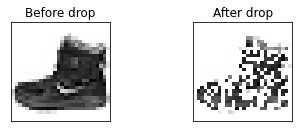

In [161]:

batch_loss=torch.zeros(batches)
batch_acc=torch.zeros(batches)
for idx in tqdm(range(batches)):
	batch_loss[idx], batch_acc[idx] = iterate_batch(idx)

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1,batches+1), batch_loss,label="Train Loss")
plt.title("CE loss")
plt.legend()
plt.xlabel("Epoch Number")

In [ ]:
dataset[0].size()